In [1]:
print("Hello World")

Hello World


## Library Imports

In [23]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Data Import

In [3]:
# Define the stock ticker symbol and the date range
ticker_symbol = 'AAPL'  # You can change this to any other stock ticker
start_date = '2018-01-01'
end_date = '2024-07-31'

# Download historical stock data
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.615883,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.608810,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.797443,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.261929,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.108677,82271200


In [4]:
# Display basic information about the dataset
stock_data.info()

# Display summary statistics
stock_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1654 entries, 2018-01-02 to 2024-07-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1654 non-null   float64
 1   High       1654 non-null   float64
 2   Low        1654 non-null   float64
 3   Close      1654 non-null   float64
 4   Adj Close  1654 non-null   float64
 5   Volume     1654 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 90.5 KB


,Open,High,Low,Close,Adj Close,Volume
count,1654.000000,1654.000000,1654.000000,1654.000000,1654.000000,1.654000e+03
mean,117.314628,118.616049,116.099658,117.409636,115.685141,1.034751e+08
std,53.964138,54.477839,53.463719,53.987990,54.393711,5.476959e+07
min,35.994999,36.430000,35.500000,35.547501,34.029236,2.404830e+07
25%,55.271250,55.878126,54.746250,55.375626,53.185692,6.720060e+07
50%,130.155006,131.430000,128.510002,130.180000,128.329567,8.957225e+07
75%,164.672497,166.387497,163.007496,165.057507,163.280472,1.244752e+08
max,236.479996,237.229996,233.089996,234.820007,234.820007,4.265100e+08


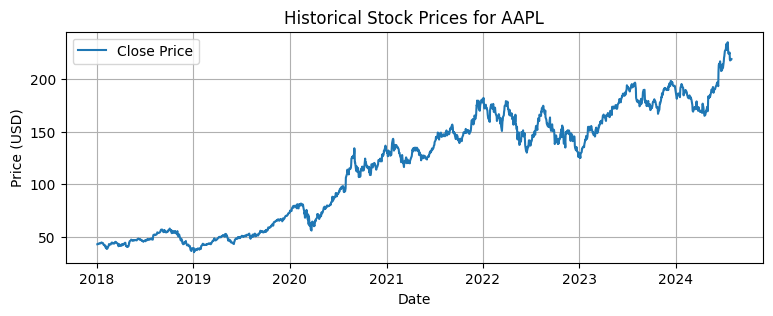

In [5]:
# Plot the historical stock prices
plt.figure(figsize=(9, 3))
plt.plot(stock_data['Close'], label='Close Price')
plt.title(f'Historical Stock Prices for {ticker_symbol}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Data Processing

In [6]:
# Check for missing values
missing_values = stock_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


There are no missing values so the cell below is not ran.

In [7]:
# Fill missing values using forward fill
## stock_data.fillna(method='ffill', inplace=True)

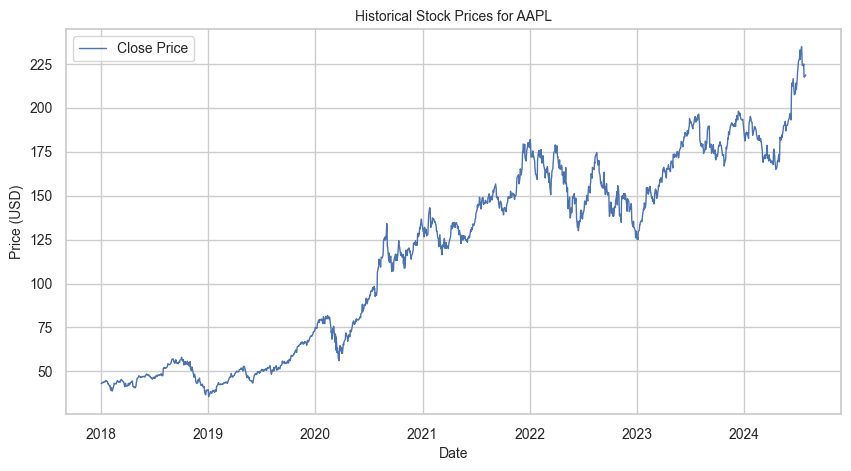

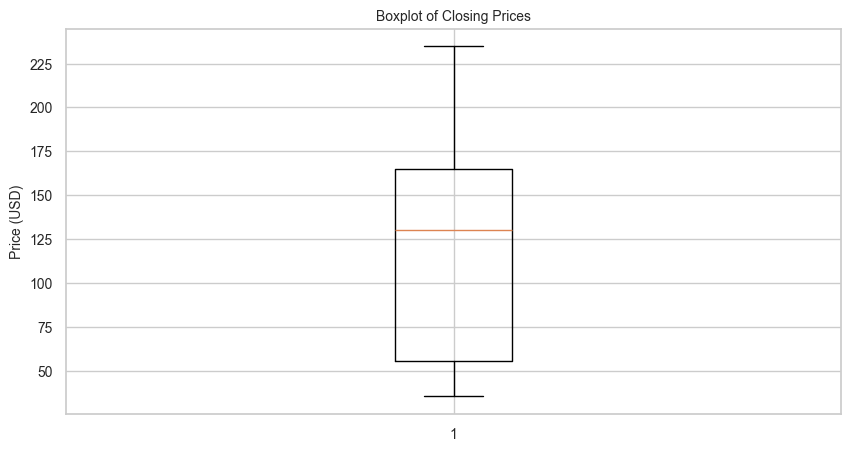

In [8]:
# Set the style and size of plots
sns.set(style='whitegrid')  # Use a grid style for easier reading

# Define the plot size and font size
plot_size = (10, 5)  # Adjust the size of the plot
font_size = 10  # Adjust the font size

# Plot the historical stock prices
plt.figure(figsize=plot_size)
plt.plot(stock_data['Close'], label='Close Price', linewidth=1)
plt.title(f'Historical Stock Prices for {ticker_symbol}', fontsize=font_size)
plt.xlabel('Date', fontsize=font_size)
plt.ylabel('Price (USD)', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size)
plt.grid(True)
plt.show()

# Boxplot to check for outliers
plt.figure(figsize=plot_size)
plt.boxplot(stock_data['Close'])
plt.title('Boxplot of Closing Prices', fontsize=font_size)
plt.ylabel('Price (USD)', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.grid(True)
plt.show()

#### Additional data creation

In [9]:
# Create a moving average column
stock_data['MA10'] = stock_data['Close'].rolling(window=10).mean()

### Splitting Data

In [10]:
# Define the target variable (Close price)
target_column = 'Close'

# Define features (you can include additional features if created)
features = ['Close', 'MA10']  # Modify if more features are added

In [11]:
from sklearn.model_selection import train_test_split

# Drop rows with NaN values after feature engineering
stock_data.dropna(inplace=True)

# Define the feature set and target
X = stock_data[features]
y = stock_data[target_column]

# Use a fixed date to split into training and test sets (e.g., 80% for training, 20% for testing)
split_date = '2023-01-01'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

In [14]:
# Function to check stationarity
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("The series is non-stationary.")
    else:
        print("The series is stationary.")

# Check if the data is stationary
check_stationarity(y_train)

ADF Statistic: -1.134912123007931
p-value: 0.7009505119352379
The series is non-stationary.


ADF Statistic: -10.41959740060558
p-value: 1.7184184519395078e-18
The series is stationary.


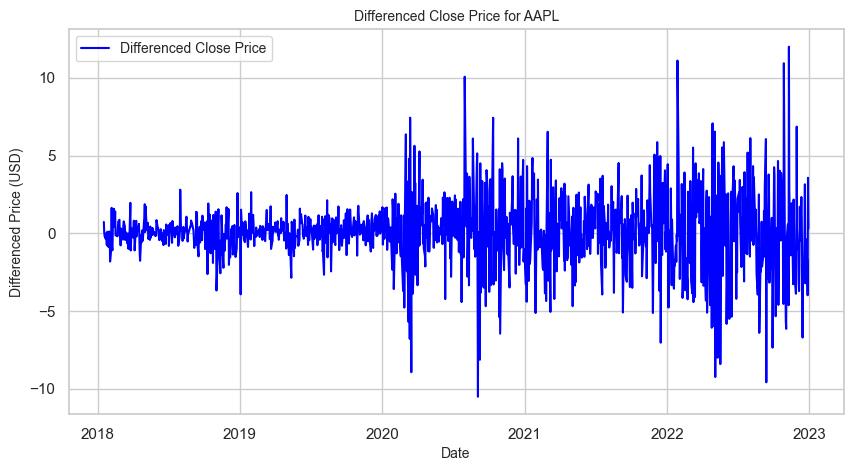

In [15]:
# Difference the data
diff_data = y_train.diff().dropna()

# Check stationarity of differenced data
check_stationarity(diff_data)

# Plot the differenced data
plt.figure(figsize=plot_size)
plt.plot(diff_data, label='Differenced Close Price', color='blue')
plt.title(f'Differenced Close Price for {ticker_symbol}', fontsize=font_size)
plt.xlabel('Date', fontsize=font_size)
plt.ylabel('Differenced Price (USD)', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.grid(True)
plt.show()

## Model Creation

In [16]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(y_train.values.reshape(-1, 1))

In [17]:
# Create a function to prepare data for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Prepare the data with time steps
time_step = 60
X_train, y_train_lstm = create_dataset(scaled_data, time_step)

# Reshape the data to fit the LSTM model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [18]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

c:\Users\zymyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train_lstm, epochs=150, batch_size=32, verbose=1)

Epoch 1/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0013
Epoch 2/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
Epoch 3/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
Epoch 4/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
Epoch 5/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
Epoch 6/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 7/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
Epoch 8/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
Epoch 9/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 10/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 11/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0010
Epoch 12/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011
Epoch 13/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011
Epoch 14/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014
Epoch 15/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - lo

## Testing the Model

In [20]:
# Prepare the test data
test_data = scaler.transform(y_test.values.reshape(-1, 1))
X_test, y_test_lstm = create_dataset(test_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [21]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


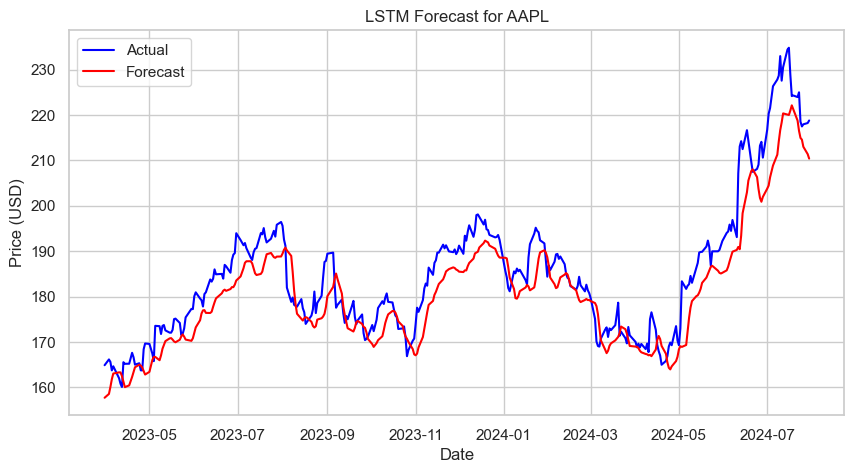

LSTM Mean Squared Error: 39.07
LSTM Mean Absolute Error: 5.05


In [24]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.index[time_step+1:], y_test.values[time_step+1:], label='Actual', color='blue')
plt.plot(y_test.index[time_step+1:], predictions, label='Forecast', color='red')
plt.title(f'LSTM Forecast for {ticker_symbol}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(y_test[time_step+1:], predictions)
mae = mean_absolute_error(y_test[time_step+1:], predictions)
print(f'LSTM Mean Squared Error: {mse:.2f}')
print(f'LSTM Mean Absolute Error: {mae:.2f}')

## End Results with different stocks

In [26]:
def run_lstm_for_stock(ticker_symbol, start_date='2018-01-01', end_date='2024-07-31'):
    # Download historical stock data
    stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

    # Extract the 'Close' prices
    y_train = stock_data['Close'][:int(len(stock_data) * 0.8)]
    y_test = stock_data['Close'][int(len(stock_data) * 0.8):]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(y_train.values.reshape(-1, 1))

    # Prepare the data with time steps
    X_train, y_train_lstm = create_dataset(scaled_data, time_step=60)

    # Reshape the data to fit the LSTM model
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train_lstm, epochs=100, batch_size=32, verbose=1)

    # Prepare the test data
    test_data = scaler.transform(y_test.values.reshape(-1, 1))
    X_test, y_test_lstm = create_dataset(test_data, time_step=60)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.index[time_step+1:], y_test.values[time_step+1:], label='Actual', color='blue')
    plt.plot(y_test.index[time_step+1:], predictions, label='Forecast', color='red')
    plt.title(f'LSTM Forecast for {ticker_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test.values[time_step+1:], predictions)
    mae = mean_absolute_error(y_test.values[time_step+1:], predictions)
    print(f'{ticker_symbol} LSTM Mean Squared Error: {mse:.2f}')
    print(f'{ticker_symbol} LSTM Mean Absolute Error: {mae:.2f}')


In [27]:
# List of stocks to analyze
stock_list = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

# Run the model for each stock
for stock in stock_list:
    print("Running function for the stock: ", stock)
    run_lstm_for_stock(stock)

[*********************100%%**********************]  1 of 1 completed

Running function for the stock:  AAPL
Epoch 1/100



c:\Users\zymyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1098
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028
Epoch 13/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028
Epoch 14/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027
Epoch 15/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024
E